In [1]:
# Step 0: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve,auc
import matplotlib.pyplot as plt

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

# Combine into one DataFrame for easier processing
df = pd.concat([X, y], axis=1) 
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables) 


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [3]:
data=df.dropna()

In [4]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [5]:
categorical_cols = ['cp', 'restecg', 'slope', 'thal']
df_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [6]:
from sklearn.preprocessing import MinMaxScaler

# columns need scalling
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

df_scaled = df_encoded.copy()

scaler = MinMaxScaler()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

In [7]:
df_scaled.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,num,cp_2,cp_3,cp_4,restecg_1,restecg_2,slope_2,slope_3,thal_6.0,thal_7.0
0,0.708333,1,0.481132,0.244292,1,0.603053,0,0.370968,0.000000,0,False,False,False,False,True,False,True,True,False
1,0.791667,1,0.622642,0.365297,0,0.282443,1,0.241935,1.000000,2,False,False,True,False,True,True,False,False,False
2,0.791667,1,0.245283,0.235160,0,0.442748,1,0.419355,0.666667,1,False,False,True,False,True,True,False,False,True
3,0.166667,1,0.339623,0.283105,0,0.885496,0,0.564516,0.000000,0,False,True,False,False,False,False,True,False,False
4,0.250000,0,0.339623,0.178082,0,0.770992,0,0.225806,0.000000,0,True,False,False,False,True,False,False,False,False


In [8]:
df_scaled.isnull().sum()

age          0
sex          0
trestbps     0
chol         0
fbs          0
thalach      0
exang        0
oldpeak      0
ca           0
num          0
cp_2         0
cp_3         0
cp_4         0
restecg_1    0
restecg_2    0
slope_2      0
slope_3      0
thal_6.0     0
thal_7.0     0
dtype: int64

C:\Users\Delta\AppData\Local\Temp\ipykernel_18932\2771259865.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_importance, palette="viridis")


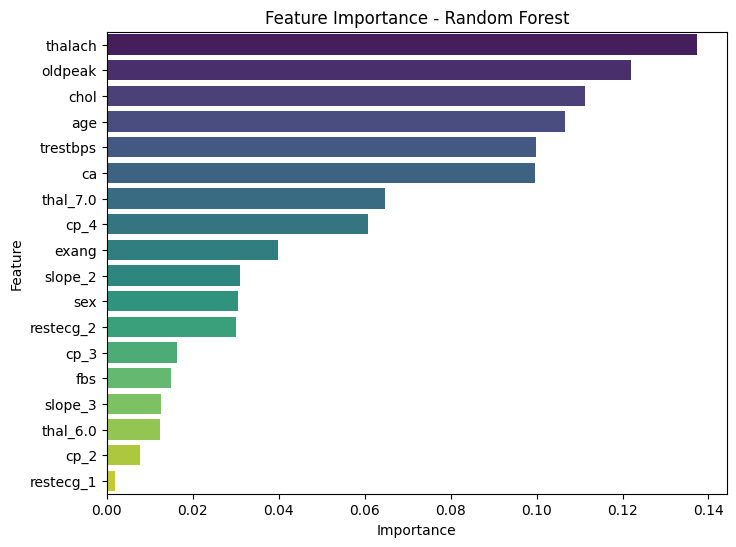

Top features selected by RFE: ['thalach', 'oldpeak', 'ca', 'cp_3', 'thal_7.0']
X_selected shape: (297, 5)

Top features by Chi-Square Test:
     Feature  Chi2 Score
17  thal_7.0   46.644612
11      cp_4   42.638819
6      exang   39.119182
8         ca   35.737851
14   slope_2   21.414294

Final Selected Features for Modeling: ['cp_4', 'oldpeak', 'thal_7.0', 'cp_3', 'ca', 'slope_2', 'exang', 'thalach']


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Feature Importance (Random Forest)
# -----------------------------
X = df_scaled.drop("num", axis=1)
y = df_scaled["num"]

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importance scores
importances = rf.feature_importances_
feat_importance = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_importance = feat_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_importance, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.show()


# -----------------------------
# 2️⃣ Recursive Feature Elimination (RFE)
# -----------------------------
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")
rfe = RFE(estimator=log_reg, n_features_to_select=5)  # select top 5 features
rfe.fit(X, y)

# Get actual selected features
X_selected = X.loc[:, rfe.support_]
print("Top features selected by RFE:", X_selected.columns.tolist())
print("X_selected shape:", X_selected.shape)  # e.g. (297, 5)



# -----------------------------
# 3️⃣ Chi-Square Test
# -----------------------------
# Chi-Square requires non-negative features (already scaled with MinMaxScaler is fine)
chi_selector = SelectKBest(score_func=chi2, k=5)  # choose top 5
chi_selector.fit(X, y)

chi_scores = pd.DataFrame({
    "Feature": X.columns,
    "Chi2 Score": chi_selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

print("\nTop features by Chi-Square Test:")
print(chi_scores.head())


# -----------------------------
# 4️⃣ Final Selection
# -----------------------------
# Example: Take intersection of methods OR top features from each
final_selected_features = list(set(X_selected) | set(chi_scores.head()["Feature"]))
print("\nFinal Selected Features for Modeling:", final_selected_features) 